# [Geo Data EDA & Feature Engineering](https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering)

### 목차
* Baseline model
* Geo Data Feature Engineering
    * Zipcode Feature Engineering
    * PCA Transformation - Lat, Long
    * K-Means Clustering - Lat, Long
        * Determine K by Elbow method
        * Determine K by CV Score
    * Haversine Distance
* Colclusion

In [1]:
# import libraries
import numpy as np
import pandas as pd
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb

/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 12

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [52]:
# Functions
def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

def train_test_split(data, do_ohe=True):
    df = data.drop(['id','price','data'], axis=1).copy()
    cat_cols = df.select_dtypes('object').columns
    for col in cat_cols:
        if do_ohe:
            ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col)
            df.drop(col, axis=1, inplace=True)
            df = pd.concat([df, ohe_df], axis=1)
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            
    train_len = data[data['data'] == 'train'].shape[0]
    X_train = df.iloc[:train_len]
    X_test = df.iloc[train_len:]
    y_train = data[data['data'] == 'train']['price']
    
    return X_train, X_test, y_train

def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):
    folds = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()
    
    for fold_, (trn_idx,val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        if verbose_eval > 0: print(f'Fold : {fold_+1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
        
        num_round = 100000
        clf = lgb.train(train_set=trn_data, params=lgb_param, num_boost_round=num_round, valid_sets=[trn_data, val_data], verbose_eval=verbose_eval, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration = clf.best_iteration)
        predictions += clf.predict(X_test, num_iteration = clf.best_iteration) / folds.n_splits
        
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
            
        if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score : {cv_fold_score:.6f}')
            
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            
    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score : {cv_score:.6f}')
    if return_cv_score_only : return cv_score
    else : return oof, predictions, cv_score ,feature_importance_df
    
def plot_feature_importance(fi_df, num_feature=20):
    cols = (fi_df[['feature','importance']]
               .groupby('feature')
               .mean()
               .sort_values(by='importance', ascending=False)[:num_feature].index)
    best_features = fi_df.loc[fi_df.feature.isin(cols)]
    
    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.title('Feature Importances (averaged over folds)')
    plt.tight_layout()
    plt.show()
    
def plot_numeric_for_regression(df, field, target_field='price'):
    df = df[df[field].notnull()]
    
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,7))
    
    sns.distplot(a=df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha':0.5}, ax=axes[0])
    sns.distplot(a=df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha':0.5}, ax=axes[0])
    plt.xlabel(field)
    plt.ylabel('Density')
    plt.legend(['Train, Test'])
    
    df_copy = df[df['data'] == 'train'].copy()
    
    sns.scatterplot(x=field, y=target_field, data=df_copy, ax=axes[1])
    plt.show()
    
def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
    df_copy = df.copy()
    if show_missing : df_copy[field] = df_copy[field].fillna(missing_value)
    df_copy = df_copy[df_copy[field].notnull()]
    
    ax1_param = 121
    ax2_param = 122
    fig_size = (16,7)
    if df_copy[field].nunique() > 30:
        ax1_param = 211
        ax2_param = 212
        fig_size = (16, 10)
        
    fig = plt.figure(figsize=fig_size)
    ax1 = plt.subplot(ax1_param)
    
    sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()) , data=df_copy, ax=ax1)
    plt.xticks(rotation=90, fontsize=11)
    
    ax2 = plt.subplot(ax2_param)
    
    df_copy = df_copy[df_copy['data'] == 'train']
    sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
    plt.xticks(rotation=90, fontsize=11)
    
    plt.show
    
def load_original_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_copy = train.copy()
    train_copy['data'] = 'train'
    test_copy = test.copy()
    test_copy['data'] = 'test'
    test_copy['price'] = np.nan
    
    # remove outlier
    train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price'] < 3000000))].reset_index(drop=True)
    
    # concat train, test data to preprocess
    data = pd.concat([train_copy, test_copy], sort=False).reset_index(drop=True)
    data = data[train_copy.columns]
    
    data.drop('date', axis=1, inplace=True)
    data['zipcode'] = data['zipcode'].astype(str)
    
    # fix skew feature
    skew_columns = ['price']
    
    for c in skew_columns:
        data[c] = np.log1p(data[c])
        
    return data

In [5]:
data = load_original_data()

print(data.shape)
data.head()

(21502, 21)


id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  12.309987         3       1.00         1180      5650     1.0   
1   1  12.100718         2       1.00          770     10000     1.0   
2   2  13.142168         3       2.00         1680      8080     1.0   
3   3  12.458779         3       2.25         1715      6819     2.0   
4   4  12.583999         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15   data  
0             0   98178  47.5112 -122.257           1340        5650  train  
1             0   98028  47.7379 -122.233           2720        8062  train  
2             0   98074  47.6168 -122.045           1800        7503  train  
3             0   98003  47.3097 -122.327           2238        6819  train  
4             0   98198  47.4095 -122.315           1650        9711  train

## Baseline model
LightGBM 5-Fold Out Of Fold Prediction을 baseline model로 사용하겠습니다.<br>
기본 데이터의 Baseline model CV 스코어는 아래와 같습니다. Categorical 데이터는 One hot encoding으로 처리하겠습니다.

In [6]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape, y_train.shape)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 87) (6468, 87) (15034,)
CV-Score : 117117.035579


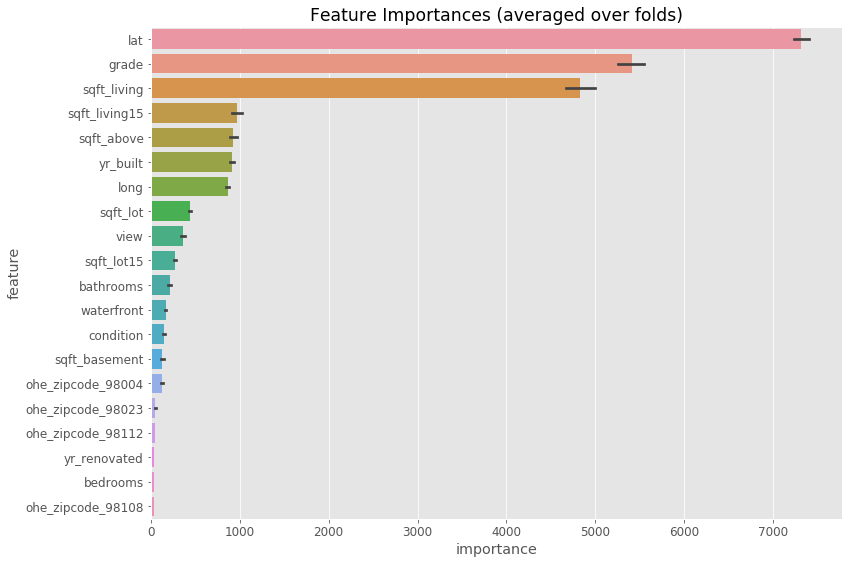

In [7]:
plot_feature_importance(fi_df)

Feature importance를 보면 zipcode가 98004, 98023, 98112, 98108인 feature가 중요한 feature로 나오는데요<br>
zipcode와 price의 boxplot을 그려보면 98004, 98112는 집값이 높은지역, 98023, 98108은 집값이 낮은지역임을 알 수 있습니다.

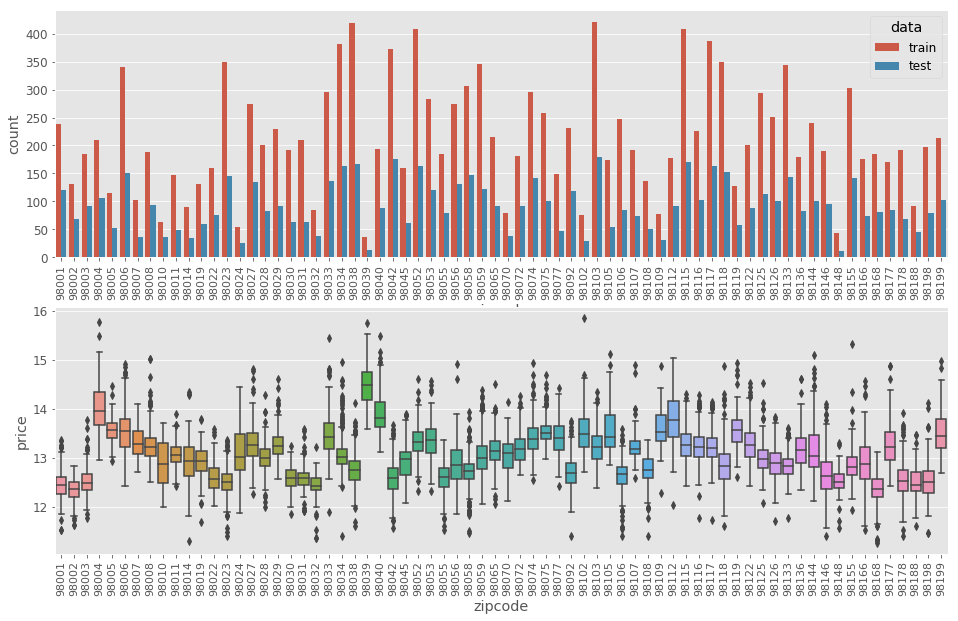

In [8]:
plot_categorical_for_regression(data, 'zipcode')

zipcode 98004, 98112, 98108, 98023 지역이 어디에 있는지 위도, 경도 데이터를 통해 확인 해 보도록 하겠습니다.

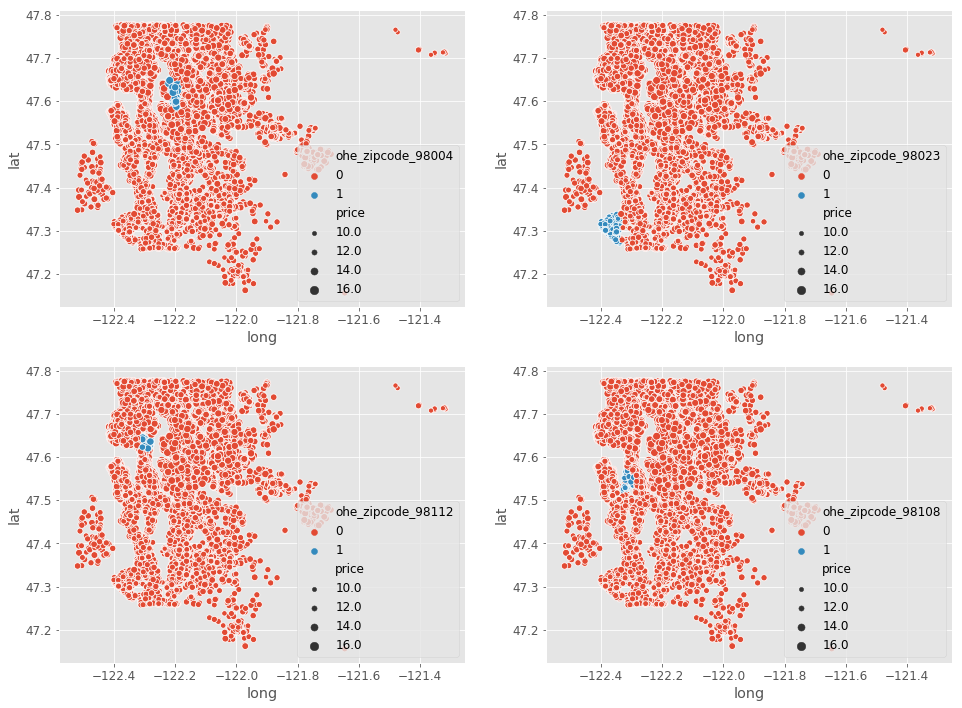

In [9]:
df = X_train
df['price'] = y_train

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(16,12))
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98004', size='price', data=df, ax=axes[0,0])
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98023', size='price', data=df, ax=axes[0,1])
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98112', size='price', data=df, ax=axes[1,0])
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98108', size='price', data=df, ax=axes[1,1])

## Zipcode Feature Engineering
Zipcode는 다섯자리로 된 숫자형의 데이터인데, 데이터를 보면 앞의 두자리는 98로 동일합니다.<br>
따라서 뒤의 세자리를 쪼개서 새로운 feature를 만들어 보겠습니다.<br>

In [10]:
data = load_original_data()

data['zipcode_3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode_4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode_5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode_34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode_45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode_35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

(21502, 27)


id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  12.309987         3       1.00         1180      5650     1.0   
1   1  12.100718         2       1.00          770     10000     1.0   
2   2  13.142168         3       2.00         1680      8080     1.0   
3   3  12.458779         3       2.25         1715      6819     2.0   
4   4  12.583999         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15   data  \
0             0   98178  47.5112 -122.257           1340        5650  train   
1             0   98028  47.7379 -122.233           2720        8062  train   
2             0   98074  47.6168 -122.045           1800        7503  train   
3             0   98003  47.3097 -122.327           2238        6819  train   
4             0   98198  47.4095 -122.315           1650        9711  train   

  zipcode_3 zipcode_4 zipcode_5 zipcode_34 zipcode_45 zipcode_35  
0       z_1       z_7       z_8       z_17       z_78       z_18  
1       z_0       z_2       z_8       z_02       z_28       z_08  
2       z_0       z_7       z_4       z_07       z_74       z_04  
3       z_0       z_0       z_3       z_00       z_03       z_03  
4       z_1       z_9       z_8       z_19       z_98       z_18

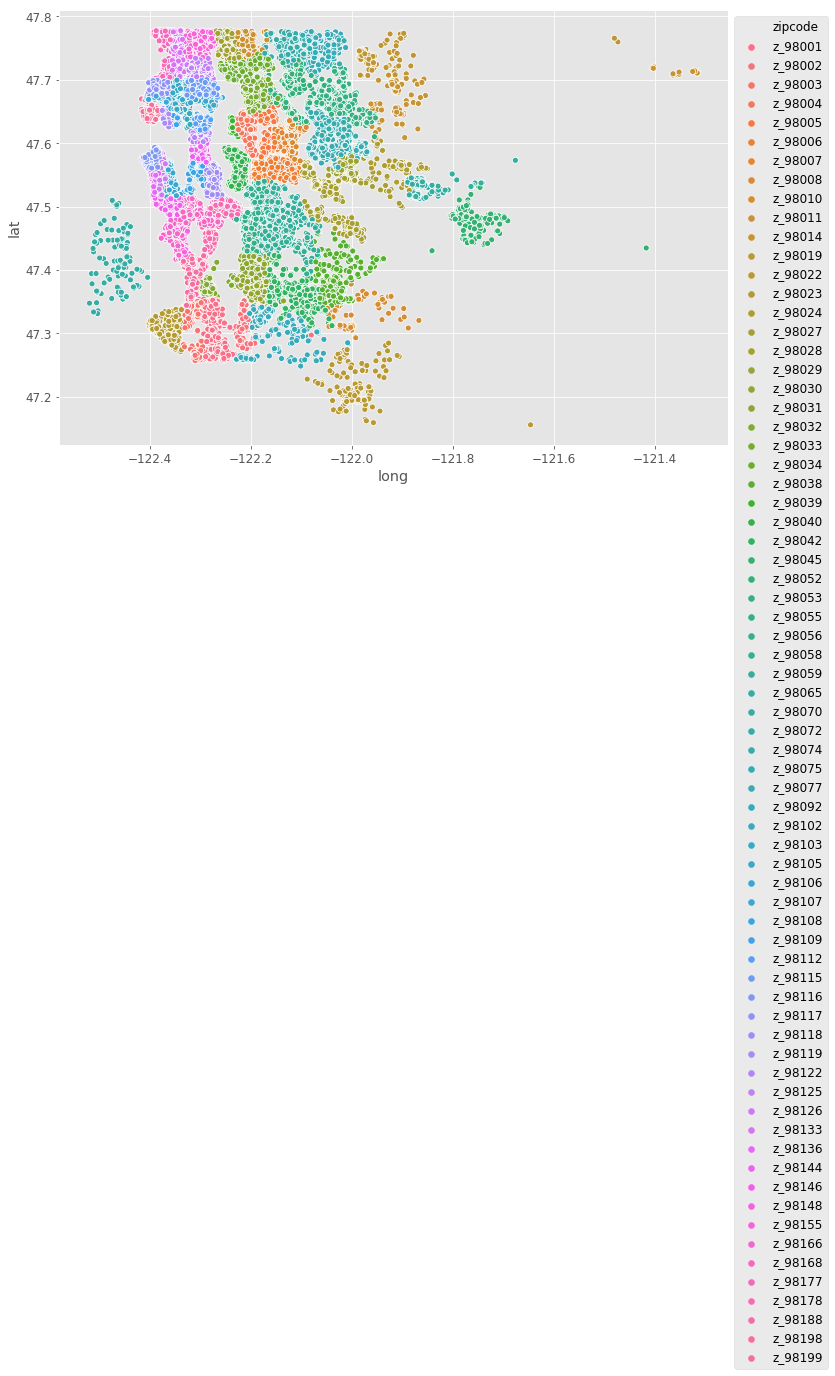

In [12]:
data['zipcode'] = 'z_' + data['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data).legend(bbox_to_anchor=(1,1))

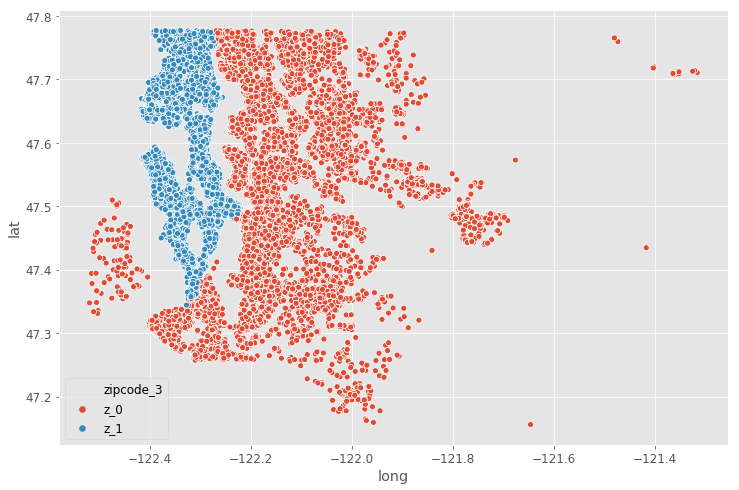

In [16]:
sns.scatterplot(x='long', y='lat', hue='zipcode_3', hue_order=np.sort(data['zipcode_3'].unique()), data=data)

In [17]:
sns.scatterplot(x='long', y='lat', hue='zipcode_4', hue_order=np.sort(data['zipcode_4'].unique()), data=data)

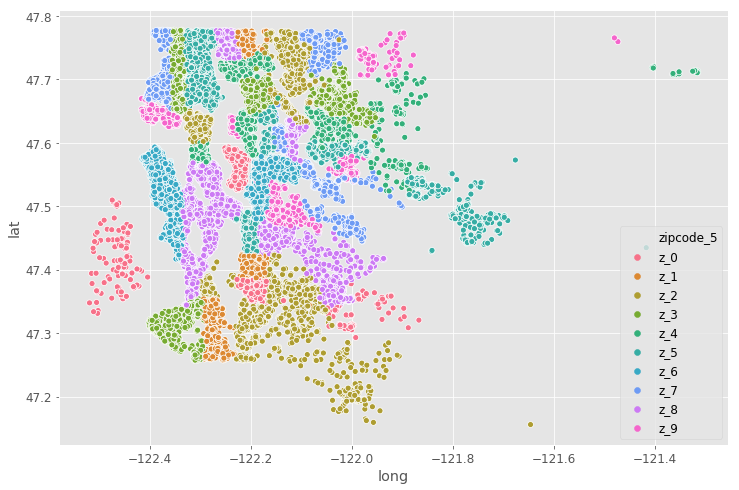

In [19]:
sns.scatterplot(x='long', y='lat', hue='zipcode_5', hue_order=np.sort(data['zipcode_5'].unique()), data=data)

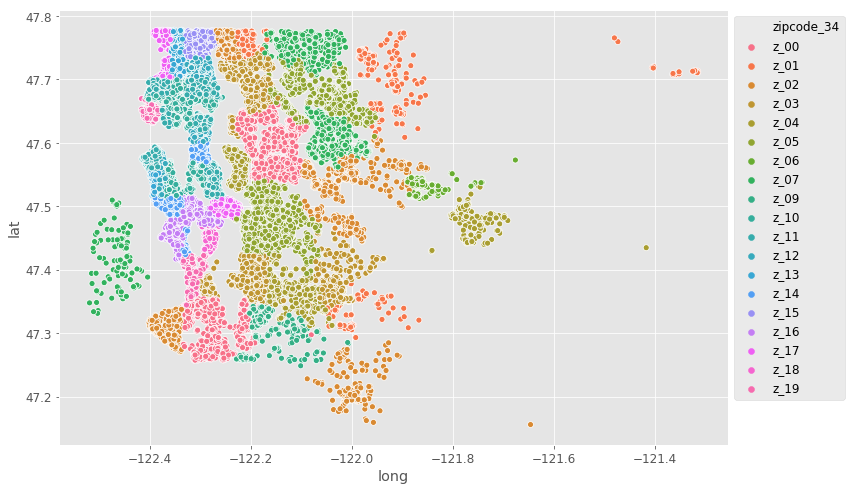

In [21]:
sns.scatterplot(x='long', y='lat', hue='zipcode_34', hue_order=np.sort(data['zipcode_34'].unique()), data=data).legend(bbox_to_anchor=(1,1))

In [24]:
sns.scatterplot(x='long', y='lat', hue='zipcode_45', hue_order=np.sort(data['zipcode_45'].unique()), data=data).legend(bbox_to_anchor=(1,1))

In [26]:
sns.scatterplot(x='long', y='lat', hue='zipcode_35', hue_order=np.sort(data['zipcode_35'].unique()), data=data).legend(bbox_to_anchor=(1,1))

In [29]:
X_train, X_test, y_train = train_test_split(data)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

CV-Score : 116084.904360


새롭게 만든 zipcode feature로 CV-score가 더 좋아진 것을 확인할 수 있습니다.

In [30]:
plot_feature_importance(fi_df)

Feature importance를 보면 zipcode-35의 18, zipcode_5의 8이 중요한 피처로 나옵니다. 확인해 보도록 하겠습니다.

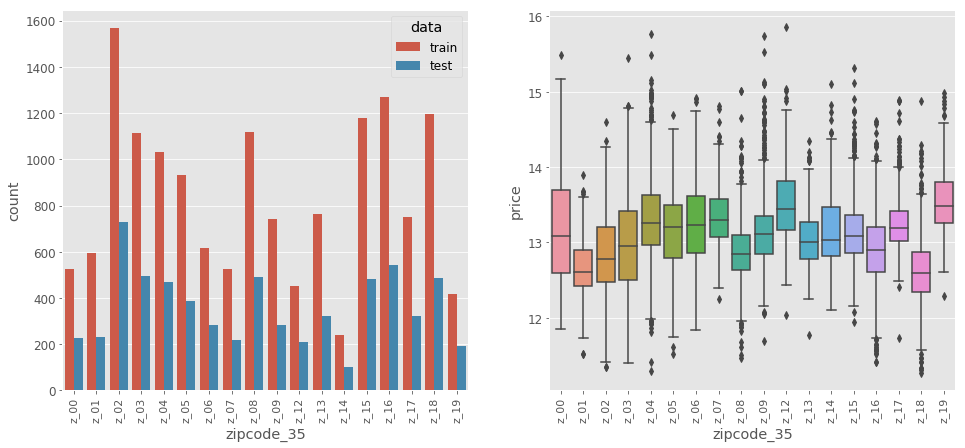

In [33]:
plot_categorical_for_regression(data, 'zipcode_35')

zipcode_35 피처의 18은 다른 곳에 비해 가격이 낮은것을 확인할 수 있습니다.

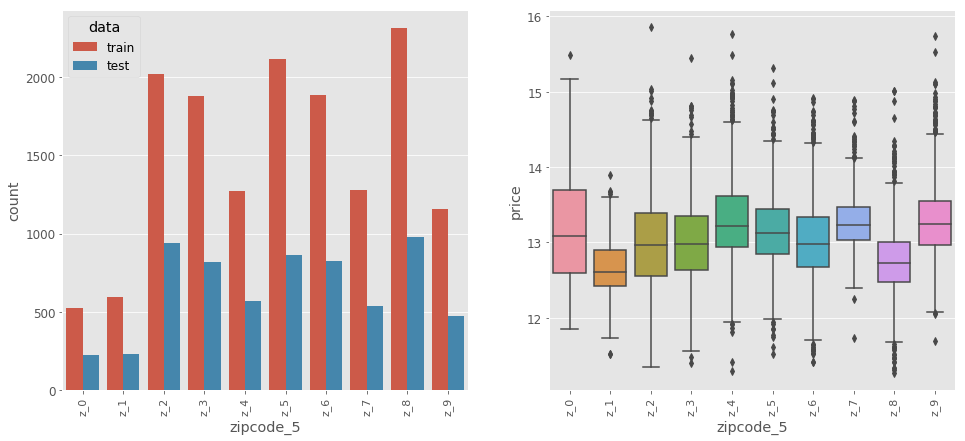

In [34]:
plot_categorical_for_regression(data, 'zipcode_5')

zipcode_5 피처의 5 역시 집값이 낮은 것을 확인할 수 있습니다.

## PCA Transformation - Lat, Long
PCA는 차원 축소에 주로 사용되는 알고리즘 입니다. 위도, 경도의 데이터만 보면 2차원의 데이터인데, 이 데이터를 차원 축소는 하지 않고 2차원 그대로 PCA Transformation을 하면 원본 데이터를 변형해서 새로운 feature를 만들 수 있습니다.

In [35]:
# pca lat, long
data = load_original_data()

coord = data[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)

data['coord_pca1'] = coord_pca[:, 0]
data['coord_pca2'] = coord_pca[:, 1]

이렇게 만들어진 feature를 2차원에 그려보면 원본 데이터가 변형되어서 새로운 feature로 변형된 것을 확인할 수 있습니다.

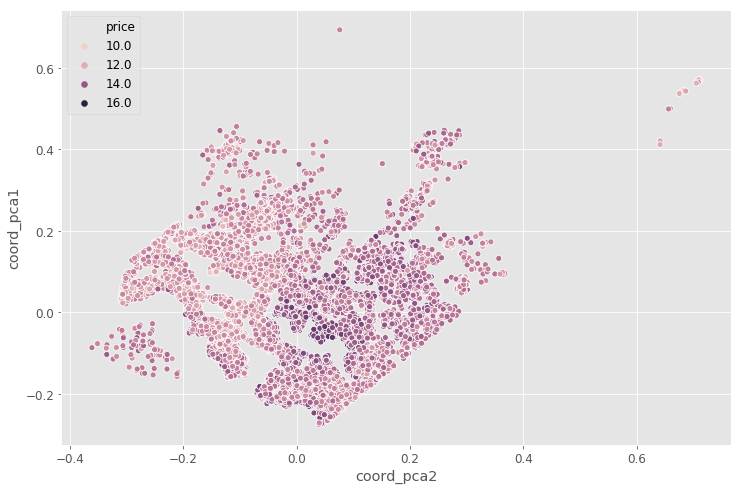

In [39]:
sns.scatterplot(x='coord_pca2', y='coord_pca1', hue='price', data=data)

In [41]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 89) (6468, 89)
CV-Score : 116045.627563


PCA를 통해 만든 feature로 CV-score가 더 좋아진 것을 확인할 수 있고, 아래 feature importance에서도 중요한 feature로 나오는 것을 확인할 수 있습니다.

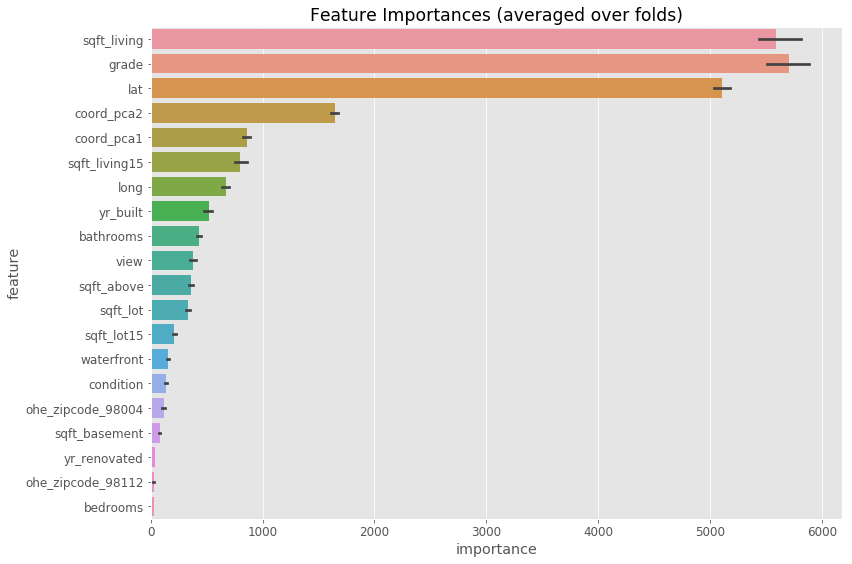

In [42]:
plot_feature_importance(fi_df)

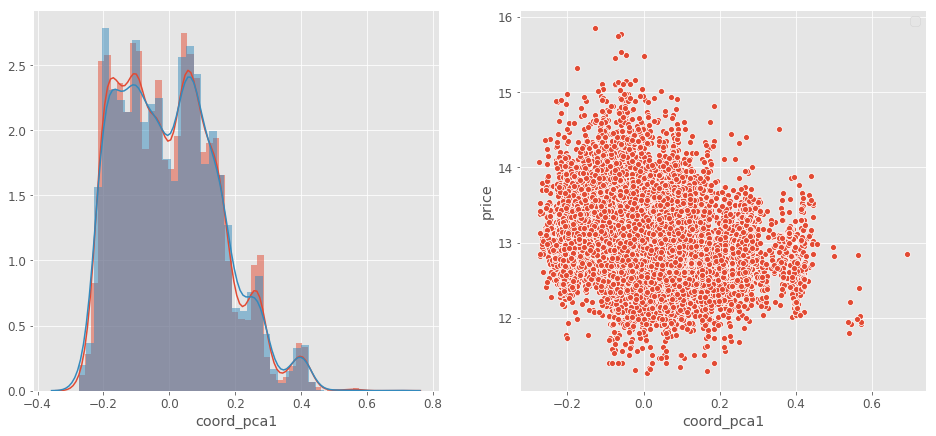

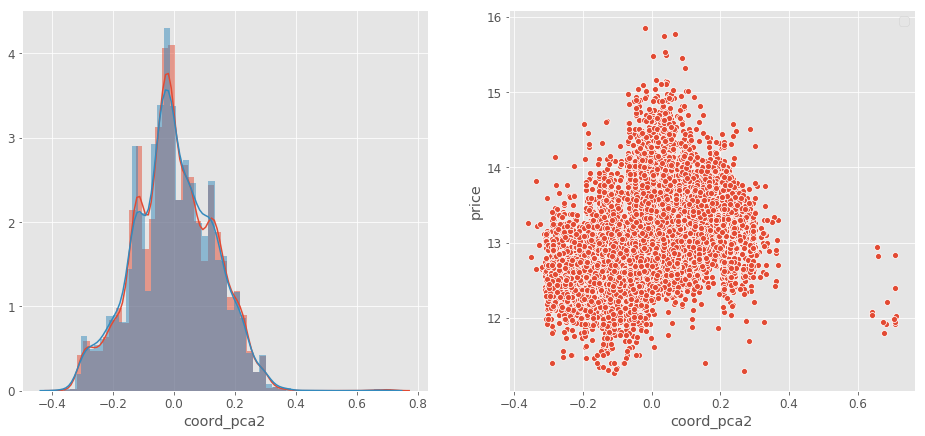

In [53]:
plot_numeric_for_regression(data, 'coord_pca1')
plot_numeric_for_regression(data, 'coord_pca2')

## K-Means Clustering - Lat, Long
K-Means clustering은 Clustering에 사용되는 지도학습 알고리즘 중에 하나입니다. 위도, 경도 데이터를 K-Means Clustering하면 가까운 지역끼리 Cluster가 만들어지기 때문에 zipcode와 유사한 개념의 새로운 feature를 만들 수 있습니다.

## Determine K by Elbow Method
K-Means Clustering에서 중요한 건 K 값을 어떻게 결정하느냐 인데요. 일반적으로 가장 많이 쓰이는 방법은 K 값을 늘려가면서 여러 개 돌려보면, Cluster간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K값을 많이 사용합니다.  이런 방식을 Elbow method라고 합니다. 먼저 Elbow Method를 통해 K값을 결정해 보겠습니다.

k :  2  cost : 506.98113400801344
k :  3  cost : 311.7459990927527
k :  4  cost : 246.30288082273648
k :  5  cost : 198.64041461037152
k :  6  cost : 157.44913426070576
k :  7  cost : 130.41658927639352
k :  8  cost : 107.04097248127474
k :  9  cost : 94.7047068957774
k : 10  cost : 86.20648228339098
k : 11  cost : 77.87311958386205
k : 12  cost : 70.78331278730434
k : 13  cost : 64.62897121771768
k : 14  cost : 59.68860120663161
k : 15  cost : 54.92440624403009


Text(0, 0.5, 'Inertia')

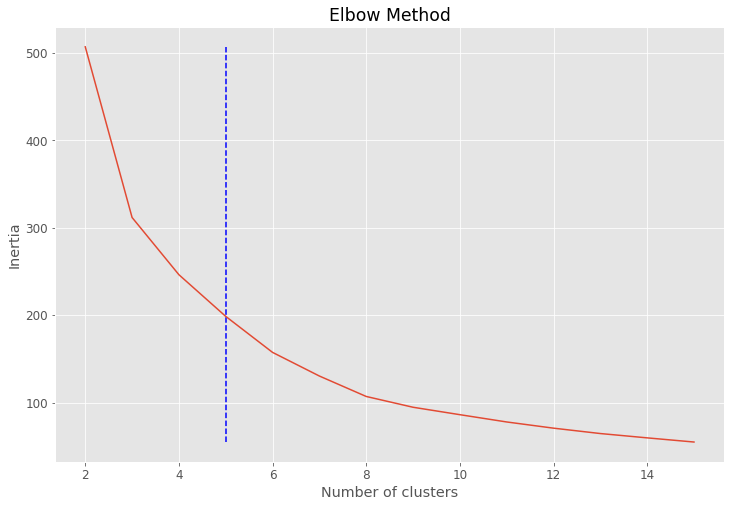

In [55]:
inertia_arr = []

k_range = range(2,16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    
    # Sum of distances of samples to their closest cluster center
    inertia = kmeans.inertia_
    print('k : {0:2}  cost : {1:}'.format(k,inertia))
    inertia_arr.append(inertia)
    
inertia_arr = np.array(inertia_arr)

plt.plot(k_range, inertia_arr)
plt.vlines(x=5, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

위의 그래프를 보면 5가 가장 적절한 K 값으로 볼 수 있습니다.

In [56]:
data = load_original_data()

# kmeans for lat, long
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(coord)
coord_cluster = kmeans.predict(coord)
data['coord_cluster'] = coord_cluster
data['coord_cluster'] = data['coord_cluster'].map(lambda x : 'c_' + str(x).rjust(2, '0'))

X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 92) (6468, 92)
CV-Score : 116602.052357


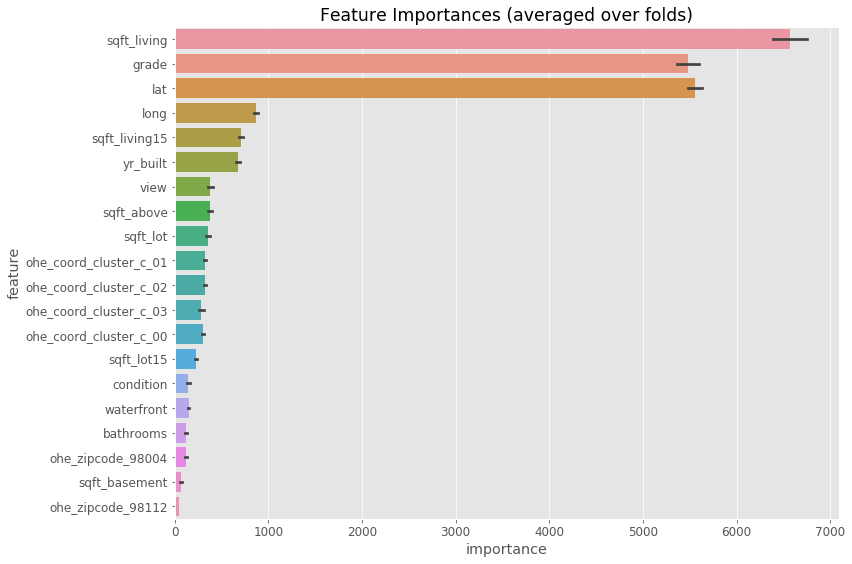

In [57]:
plot_feature_importance(fi_df)

## Determine K by CV Score
또, 다른 방식으로 K 값을 결정해볼 수 도 있는데요. K-Means Clustering으로 만든 feature를 Regression Model에서 결국 사용하기 때문에 K 값도 하나의 하이퍼 파라미터로 보고 CV Score가 가장 낮게 나오는 K를 선택해서 사용할 수도 있습니다.

In [59]:
k_range = range(2, 80, 5)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x : 'c_' + str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)
    
    print('k :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

k : 2
CV-Score : 115902.721493

k : 7
CV-Score : 117012.821948

k : 12
CV-Score : 117633.381409

k : 17
CV-Score : 117980.012678

k : 22
CV-Score : 115394.302373

k : 27
CV-Score : 116387.329731

k : 32
CV-Score : 114912.070556

k : 37
CV-Score : 116293.213373

k : 42
CV-Score : 116896.247402

k : 47
CV-Score : 117466.252997

k : 52
CV-Score : 117855.937920

k : 57
CV-Score : 117774.707390

k : 62
CV-Score : 117242.539181

k : 67
CV-Score : 118321.452717

k : 72
CV-Score : 117634.792546

k : 77
CV-Score : 117457.471212



In [60]:
k_range = range(28, 37)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x : 'c_' + str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)
    
    print('k :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

k : 28
CV-Score : 116885.453464

k : 29
CV-Score : 117193.354172

k : 30
CV-Score : 116309.474791

k : 31
CV-Score : 116837.138863

k : 32
CV-Score : 114912.070556

k : 33
CV-Score : 115573.155910

k : 34
CV-Score : 116697.662762

k : 35
CV-Score : 115208.925945

k : 36
CV-Score : 116782.564807



K 값이 32일 때 CV Score가 가장 좋게 나오는 것을 확인할 수 있습니다. Elbow Method로 K 값을 선택했을 때 보다 CV Score 기준으로 K를 선택할 때가 더 모델 성능이 좋기 때문에 최종 K값은 32로 사용하겠습니다. 

In [61]:
# k means for lat, long
kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord)
coord_cluster = kmeans.predict(coord)
data['coord_cluster'] = coord_cluster
data['coord_cluster'] = data['coord_cluster'].map(lambda x : 'c_' + str(x).rjust(2, '0'))

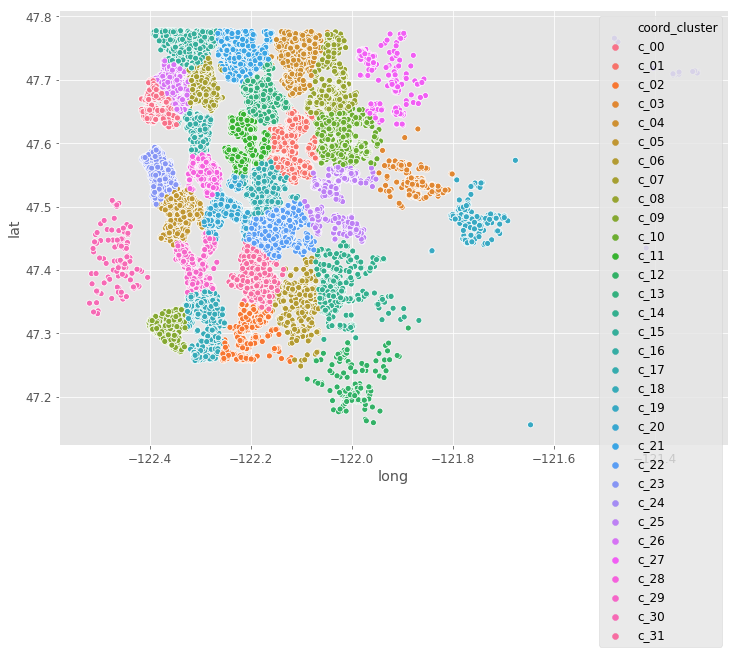

In [63]:
sns.scatterplot(x='long', y='lat', hue='coord_cluster', hue_order=np.sort(data['coord_cluster'].unique()), data=data)

In [64]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective' : 'regression',
    'learning_rate' : 0.05,
    'num_leaves' : 15,
    'bagging_fraction' : 0.7,
    'bagging_freq' : 1,
    'feature_fraction' : 0.7,
    'seed' : RANDOM_SEED,
    'metric' : ['rmse']
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 119) (6468, 119)
CV-Score : 114912.070556


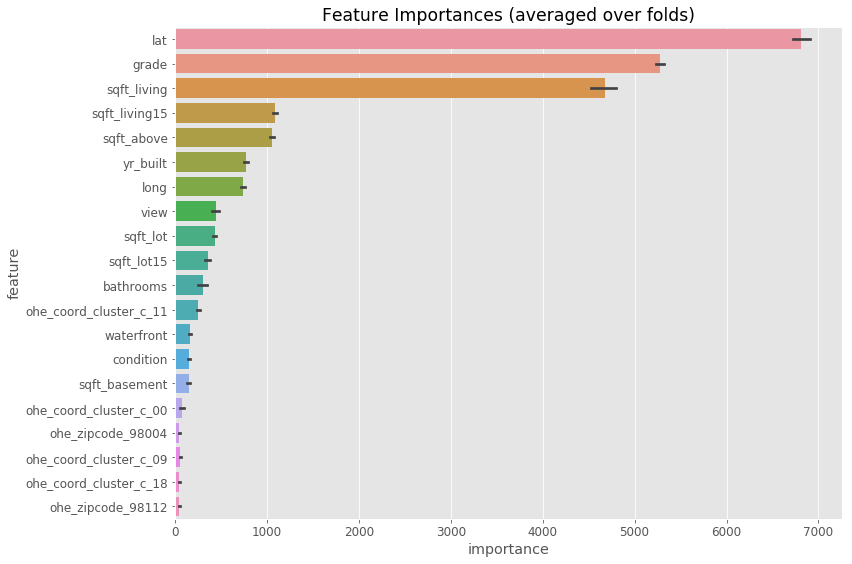

In [65]:
plot_feature_importance(fi_df)

Feature importance를 보면 11번 cluster가 중요한 Feature임을 확인할 수 있습니다. 아래 그래프에서 11번 cluster의 위치를 확인 해 볼 수 있습니다.

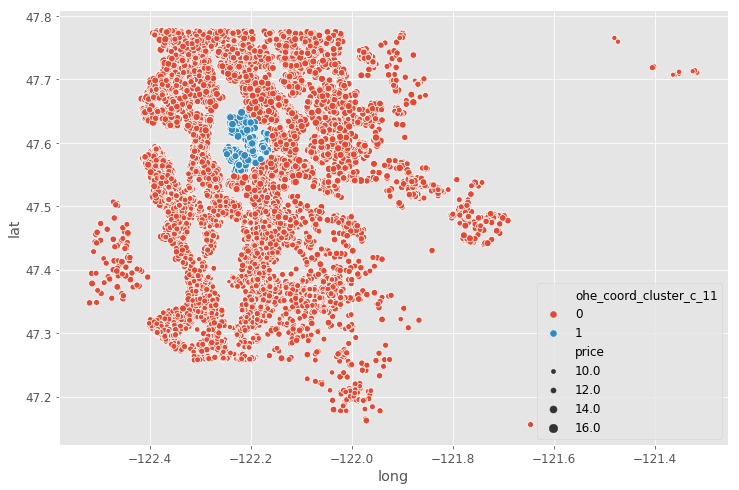

In [66]:
df = X_train
df['price'] = y_train
sns.scatterplot(x='long', y='lat', hue='ohe_coord_cluster_c_11', size='price', data=df)

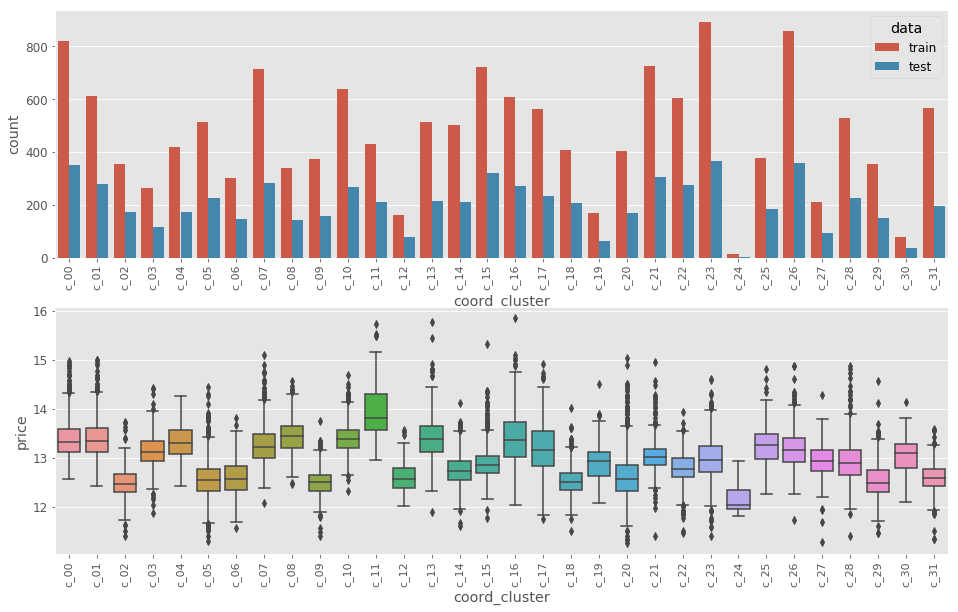

In [67]:
plot_categorical_for_regression(data, 'coord_cluster')

위 그래프를 보면 11번 cluster 지역이 집값이 가장 비싼 지역임을 확인할 수 있습니다.

## [Haversine Distance](https://en.wikipedia.org/wiki/Haversine_formula)
마지막으로 Haversine Distance를 사용한 feature 생성입니다. Haversine Distance는 두 개의 위도, 경도 좌표에서 지구의 곡률을 고려해 두 좌표 간의 거리를 구하는 방법입니다.<br>
아래의 function으로 Haversine Distance를 구할 수 있습니다.

In [71]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

주어진 데이터에서 위도, 경도의 최소값과 최대값 두 개의 좌표에 대해 거리를 구해보면 113.88km가 나오는데, 가장 먼 거리의 거리가 이정도라는 얘기가 되겠네요.

In [72]:
print(data['lat'].min(), data['lat'].max(), data['long'].min(), data['long'].max())

haversine_dist = haversine_array(data['lat'].min(), data['long'].min(), data['lat'].max(), data['long'].max())
print(f'max distance : {haversine_dist:.2f}km')

47.1559 47.7776 -122.519 -121.315
max distance : 113.88km


아래는 id가 0인 집과 전체 집과의 거리를 구한 데이터입니다. 0번 집과 가까운 이웃은 집값이 비슷할 확률이 높기 때문에 거리를 기반으로 가까운 집의 데이터를 확인할 수 있습니다. 이런식으로 전체 집들의 Haversine distance를 구하면 나와 가까운 이웃집들의 정보를 새로운 feature로 활용할 수 있습니다.

In [79]:
neightbor_df = pd.DataFrame()
lat2 = data['lat'].values
long2 = data['long'].values

lat1 = data.loc[0, 'lat']  # id = 0 house lat
long1 = data.loc[0, 'long']  # id = 0 house long
dist_arr = haversine_array(lat1, long1, lat2, long2)

neighbor_df = pd.DataFrame({
    'id' : np.tile(np.array([data.loc[0, 'id']]), data.shape[0]),
    'neighbor_id' : data['id'],
    'neighbor_lat' : lat2,
    'neighbor_long' : long2,
    'distance' : dist_arr
})

print(neighbor_df.shape)
neighbor_df.head()

(21502, 5)


id  neighbor_id  neighbor_lat  neighbor_long   distance
0   0            0       47.5112       -122.257   0.000000
1   0            1       47.7379       -122.233  25.271977
2   0            2       47.6168       -122.045  19.771055
3   0            3       47.3097       -122.327  23.016635
4   0            4       47.4095       -122.315  12.120049

아래는 0번 집의 반경 5km 이내의 이웃들을 그려본 그래프입니다.

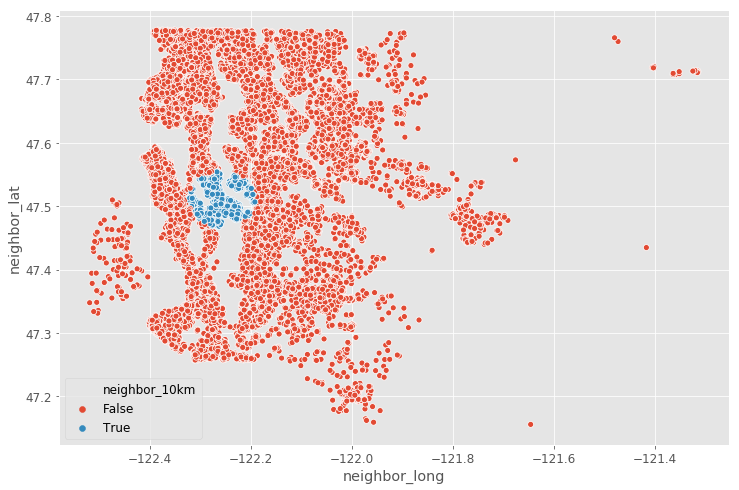

In [80]:
neighbor_df['neighbor_10km'] = neighbor_df['distance'] <= 5
sns.scatterplot(x='neighbor_long', y='neighbor_lat', hue='neighbor_10km', data=neighbor_df)

## Conclusion
지금까지 위치 데이터를 활용한 Feature Engineering을 살펴봤습니다. 특히, 마지막에 Haversine Distance를 사용하면 각 집에서 가까운 이웃집을 계산할 수 있고, 이를 바탕으로 다양한 feature들을 만들어 낼 수 있습니다.